The MIT License (MIT)

Copyright (c) 2021 NVIDIA CORPORATION

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# GRU with MultiStage Session-based Matrix Factorization head

In [1]:
import os, sys

VER = 44
os.environ["CUDA_VISIBLE_DEVICES"]="0"


TRAIN_WITH_TEST = True
# ONLY DO THIS MANY FOLDS
DO_FOLDS = 5
# MAKE SUBMISSION OR NOT
DO_TEST = True

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import cudf
import cupy
import gc
from sklearn.model_selection import GroupKFold
pd.set_option('display.max_columns', None)

pd.__version__, cudf.__version__

('1.1.3', '0+untagged.1.ga6296e3')

# Metric Calculation

In [4]:
# Return top4 metric
# istest: flag to select if metric should be computed in 0:train, 1:test, -1:both
# pos: select which city to calculate the metric, 0: last, 1: last-1, 2:last-2 , -1: all
# the input `val` dataframe must contains the target `city_id` and the 4 recommendations as: rec0, res1, rec2 and rec3

def top4_metric( val, istest=0, pos=0 , target='city_id'):
    
    if istest>=0:
        val = val.loc[ (val.submission==0) & (val.istest == istest) ]
    else:
        val = val.loc[ (val.submission==0) ]

    if pos >= 0:
        top1 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec0']
        top2 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec1']
        top3 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec2']
        top4 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec3']
    else:
        top1 = val[target] == val['rec0']
        top2 = val[target] == val['rec1']
        top3 = val[target] == val['rec2']
        top4 = val[target] == val['rec3']
        
    return (top1|top2|top3|top4).mean()    

# Feature Engineering

In [5]:
%%time
PATH = './'
raw = cudf.read_csv('../../00_Data/train_and_test_2.csv')
print(raw.shape)

(1545502, 16)
CPU times: user 899 ms, sys: 717 ms, total: 1.62 s
Wall time: 2.26 s


In [6]:
raw['reverse'] = 0
raw.head()

/opt/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/opt/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse
0,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,0
1,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,0
2,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,0
3,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,0
4,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,1,0,4,0


In [7]:
reverse = raw.copy()
reverse['reverse'] = 1
reverse['utrip_id'] = reverse['utrip_id']+'_r'

In [8]:
reverse['icount'] = reverse['dcount'].copy()

In [9]:
reverse = reverse.sort_values(['utrip_id', 'icount'], ascending=False)
raw = cudf.concat([raw, reverse], axis=0)
raw['sorting'] = cupy.asarray(range(raw.shape[0]))
del reverse
gc.collect()

10883

In [10]:
raw['utrip_id'+'_'], mp = raw['utrip_id'].factorize()

In [11]:
%%time

raw['checkin'] = cudf.to_datetime(raw.checkin, format="%Y-%m-%d")
raw['checkout'] = cudf.to_datetime(raw.checkout, format="%Y-%m-%d")

CPU times: user 6.92 ms, sys: 10.1 ms, total: 17 ms
Wall time: 16.9 ms


In [12]:
%%time

# ENGINEER MONTH, WEEKDAY, and LENGTH OF STAY FEATURES
raw['mn'] = raw.checkin.dt.month
raw['dy1'] = raw.checkin.dt.weekday
raw['dy2'] = raw.checkout.dt.weekday
raw['length'] = (raw.checkout - raw.checkin).dt.days

# ENGINEER WEEKEND AND SEASON
raw['day_name']= raw.checkin.dt.weekday
raw['isweekend']=raw['day_name'].isin([5,6]).astype('int8')


CPU times: user 23.3 ms, sys: 39.1 ms, total: 62.4 ms
Wall time: 78 ms


In [13]:
df_season = cudf.DataFrame({'mn': range(1,13), 'season': ([0]*3)+([1]*3)+([2]*3)+([3]*3)})

In [14]:
raw=raw.merge(df_season, how='left', on='mn')
raw = raw.sort_values(['sorting'], ascending=True)

In [15]:
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,length,day_name,isweekend,season
2112,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,0,0,8,5,6,1,5,1,2
2113,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,0,1,8,6,1,2,6,1,2
2114,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,0,2,8,1,3,2,1,0,2
2115,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,0,3,8,3,6,3,3,0,2
2116,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,2,0,4,0,4,4,5,0,2,5,1,1


In [3]:
def shift_feature(df, groupby_col, col, offset, nan=-1, colname=''):
    df[colname] = df[col].shift(offset)
    df.loc[df[groupby_col]!=df[groupby_col].shift(offset), colname] = nan

In [16]:
# WEIRD FEATURE IS DIFFERENT FOR REVERSE AND NORMAL
shift_feature(raw, 'utrip_id_', 'checkout', 1, None, 'checkout_lag1')
raw['gap'] = (raw.checkin - raw.checkout_lag1).dt.days.fillna(-1) 

In [17]:
%%time

# REVERSE ICOUNT
raw['dcount'] = raw['N']-raw['icount']-1

CPU times: user 4.22 ms, sys: 216 µs, total: 4.44 ms
Wall time: 4.13 ms


In [18]:
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,length,day_name,isweekend,season,checkout_lag1,gap
2112,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,0,0,8,5,6,1,5,1,2,<NA>,-1
2113,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,0,1,8,6,1,2,6,1,2,2016-08-14 00:00:00.000000000,0
2114,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,0,2,8,1,3,2,1,0,2,2016-08-16 00:00:00.000000000,0
2115,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,0,3,8,3,6,3,3,0,2,2016-08-18 00:00:00.000000000,0
2116,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,2,0,4,0,4,4,5,0,2,5,1,1,<NA>,-1


In [19]:
# LABEL ENCODE CATEGORICAL
CATS = ['city_id','mn','dy1','dy2','length','device_class','affiliate_id','booker_country',
        'hotel_country','icount','dcount','gap','isweekend', 'season']
MAPS = []
for c in CATS:
    raw[c+'_'], mp = raw[c].factorize()
    MAPS.append(mp)
    print('created',c+'_')

created city_id_
created mn_
created dy1_
created dy2_
created length_
created device_class_
created affiliate_id_
created booker_country_
created hotel_country_
created icount_
created dcount_
created gap_
created isweekend_
created season_


In [21]:
LAGS = 5
EC = 400

# ENGINEER LAG FEATURES
for i in range(1,LAGS+1):
    shift_feature(raw, 'utrip_id_', 'city_id_', i, -1, f'city_id_lag{i}')

In [22]:
shift_feature(raw, 'utrip_id_', 'hotel_country_', i, -1, 'hotel_lag1')

In [23]:
# TOTAL DURATION AND FIRST CITY
tmpA = raw[raw['icount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['dcount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total']],on='utrip_id',how='left')

In [24]:
tmpD = raw[raw['dcount']==0][['utrip_id', 'city_id_']]
tmpD.columns = ['utrip_id', 'city_first']
raw = raw.merge(tmpD,on='utrip_id',how='left')

In [25]:
tmpA = raw[raw['dcount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['icount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total_r'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total_r']],on='utrip_id',how='left')
raw.loc[raw['length_total']<0,'length_total'] = raw.loc[raw['length_total']<0,'length_total_r']

In [26]:
raw[raw['utrip_id'].isin(['999944_1','999944_1_r'])]

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
1486646,999944,2016-06-23,2016-06-24,17944,desktop,4541,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,0,3,0,1545494,6,3,4,4,0,0,1557,2,59,3,0,51,0,1,-1,-1,-1,-1,-1,-1,7,10599,-5
1486647,999944,2016-06-24,2016-06-27,47075,desktop,2322,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,1,2,0,1545495,6,4,0,0,2,0,778,2,59,2,1,52,0,1,10599,-1,-1,-1,-1,-1,7,10599,-5
1486648,999944,2016-06-27,2016-06-29,228,desktop,384,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,2,1,0,1545496,6,0,2,2,1,0,149,2,59,1,2,52,0,1,27893,10599,-1,-1,-1,-1,7,10599,-5
1486649,999944,2016-06-29,2016-06-30,62930,desktop,4541,Gondal,Glubbdubdrib,999944_1,0,1,0,4,576692,3,0,0,1545497,6,2,3,3,0,0,1557,2,59,0,3,52,0,1,126,27893,10599,-1,-1,-1,7,10599,-5
1563970,999944,2016-06-29,2016-06-30,62930,desktop,4541,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,0,3,1,1545506,6,2,3,3,0,0,1557,2,59,3,0,51,0,1,-1,-1,-1,-1,-1,-1,7,37220,7
1563971,999944,2016-06-27,2016-06-29,228,desktop,384,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,1,2,1,1545507,6,0,2,2,1,0,149,2,59,2,1,49,0,1,37220,-1,-1,-1,-1,-1,7,37220,7
1563972,999944,2016-06-24,2016-06-27,47075,desktop,2322,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,2,1,1,1545508,6,4,0,0,2,0,778,2,59,1,2,47,0,1,126,37220,-1,-1,-1,-1,7,37220,7
1563973,999944,2016-06-23,2016-06-24,17944,desktop,4541,Gondal,Glubbdubdrib,999944_1_r,0,1,0,4,576693,3,0,1,1545509,6,3,4,4,0,0,1557,2,59,0,3,48,0,1,27893,126,37220,-1,-1,-1,7,37220,7


# Finish Feature Engineering

In [27]:
# CONVERT -1 TO 0
cols = [f'city_id_lag{i}' for i in range(LAGS,0,-1)]
for c in cols+['city_id_','city_first']+['hotel_lag1']:
    raw[c] += 1
    print(c)

city_id_lag5
city_id_lag4
city_id_lag3
city_id_lag2
city_id_lag1
city_id_
city_first
hotel_lag1


In [28]:
# MOVE RARE CITIES INTO COMMON CLASS
RARE = 9*2 #x2 because data has doubled
tmp = raw.city_id_.value_counts()
idx = tmp.loc[tmp<=RARE].index.values
print('rare city ct under <=%i'%RARE, len(idx),'total cities =',len(tmp) )

mx = raw.city_id_.max()+1
for c in cols+['city_first']:
    raw.loc[raw[c].isin(idx),c] = mx

rare city ct under <=18 28744 total cities = 39902


In [29]:
# VERIFY LAG LOOKS RIGHT
raw[['city_id_','city_id_','icount']+cols].head()

,city_id_,icount,city_id_lag5,city_id_lag4,city_id_lag3,city_id_lag2,city_id_lag1
0,18022,4,0,0,0,0,0
1,10866,3,0,0,0,0,18022
2,39381,2,0,0,0,18022,10866
3,6005,1,0,0,18022,10866,39381
4,28084,0,0,18022,10866,39381,6005


In [30]:
FEATURES = ['mn_', 'dy1_','dy2_','length_','device_class_',  'affiliate_id_', 'booker_country_',
       'hotel_lag1','icount','dcount','city_first','length_total','gap_','isweekend_', 'season_'] + cols
TARGET = ['city_id_']

**Note that the order should be ['city_id_lag3', 'city_id_lag2', 'city_id_lag1'] in the order of time for the sake of RNN**

In [31]:
cols

['city_id_lag5',
 'city_id_lag4',
 'city_id_lag3',
 'city_id_lag2',
 'city_id_lag1']

# GRU-MS-SMF 5 Fold Model

In [32]:
os.environ['TF_MEMORY_ALLOCATION'] = "0.6" # fraction of free memory

In [33]:
import tensorflow as tf
tf.__version__

'2.5.0-dev20201121'

In [34]:
gpus = tf.config.list_physical_devices('GPU')

In [35]:
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*20)]
)

# Define Embeddings

In [36]:
# EMBEDDING INPUT SIZES
cts = []
for c in FEATURES:
    mx = raw[c].max()
    cts.append(mx+1)
    print(c,mx+1)

mn_ 12
dy1_ 7
dy2_ 7
length_ 30
device_class_ 3
affiliate_id_ 3611
booker_country_ 5
hotel_lag1 196
icount 48
dcount 48
city_first 39904
length_total 319
gap_ 75
isweekend_ 2
season_ 4
city_id_lag5 39904
city_id_lag4 39904
city_id_lag3 39904
city_id_lag2 39904
city_id_lag1 39904


In [37]:
# EMBEDDING OUTPUT SIZES
#EC = 400
cts2 = [4,3,3,6,2,60,3,14,7,7,200,18,9,3,4]+[EC]*len(cols)

In [38]:
emb_map = {i:(j,k) for i,j,k in zip(FEATURES, cts, cts2)}
emb_map

{'mn_': (12, 4),
 'dy1_': (7, 3),
 'dy2_': (7, 3),
 'length_': (30, 6),
 'device_class_': (3, 2),
 'affiliate_id_': (3611, 60),
 'booker_country_': (5, 3),
 'hotel_lag1': (196, 14),
 'icount': (48, 7),
 'dcount': (48, 7),
 'city_first': (39904, 200),
 'length_total': (319, 18),
 'gap_': (75, 9),
 'isweekend_': (2, 3),
 'season_': (4, 4),
 'city_id_lag5': (39904, 400),
 'city_id_lag4': (39904, 400),
 'city_id_lag3': (39904, 400),
 'city_id_lag2': (39904, 400),
 'city_id_lag1': (39904, 400)}

In [39]:
# TARGET SOFTMAX OUTPUT SIZE
t_ct = raw['city_id_'].max()+1
t_ct

39903

# Build Model

In [40]:
N_CITY = 50

class Linear(tf.keras.layers.Layer):
    def __init__(self, H, activation='relu'):
        super(Linear, self).__init__()
        self.dense = tf.keras.layers.Dense(H)
        self.bn = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x
    

class WeightedSum(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightedSum, self).__init__(name='weighted_sum')

    def build(self, input_shape):
        self.w1 = self.add_weight(name='w1',shape=None,dtype=tf.float32,
                                 trainable=True)
        self.w2 = self.add_weight(name='w2',shape=None,dtype=tf.float32,
                                 trainable=True)
        
    def call(self, x1, x2, x3):
        w1 = tf.nn.sigmoid(self.w1)
        w2 = tf.nn.sigmoid(self.w2)
        x1 = tf.stop_gradient(x1)
        x2 = tf.stop_gradient(x2)
        x3 = tf.stop_gradient(x3)
        return (x1 + x2*w1 + x3*w2)/(1+w1+w2)
    
class EmbDotSoftMax(tf.keras.layers.Layer):
    def __init__(self):
        super(EmbDotSoftMax, self).__init__()
        self.d1 = tf.keras.layers.Dense(EC) 
    
    def call(self, x, top_city_emb, top_city_id, prob):
        emb_pred = self.d1(x) # B,EC
        emb_pred = tf.expand_dims(emb_pred, axis=1) #B,1,EC
        x = emb_pred*top_city_emb #B,N_CITY,EC
        x = tf.math.reduce_sum(x, axis=2) #B,N_CITY
        x = tf.nn.softmax(x) #B,N_CITY

        rowids = tf.range(0,tf.shape(x)[0]) # B
        rowids = tf.transpose(tf.tile([rowids],[N_CITY,1])) # B,N_CITY

        idx = tf.stack([rowids,top_city_id],axis=2) # B, N_CITY, 2
        idx = tf.cast(idx, tf.int32)
        prob = tf.scatter_nd(idx, x, tf.shape(prob)) + 1e-6
        return prob
    

def build_model():
    inp = tf.keras.layers.Input(shape=(len(FEATURES),))
    embs = []
    i,j = emb_map['city_id_lag1']
    e_city = tf.keras.layers.Embedding(i,j)
    city_embs = []
    
    for k,f in enumerate(FEATURES):
        i,j = emb_map[f]
        if f.startswith('city_id'):
            city_embs.append(e_city(inp[:,k]))
        else:
            e = tf.keras.layers.Embedding(i,j)
            embs.append(e(inp[:,k]))
    
    xc = tf.stack(city_embs, axis=1) # B, T, F
    xc = tf.keras.layers.GRU(EC, activation='tanh')(xc)
    
    x = tf.keras.layers.Concatenate()(embs)
    x = tf.keras.layers.Concatenate()([x,xc])
    
    x1 = Linear(512+256, 'relu')(x)
    x2 = Linear(512+256, 'relu')(x1)
    prob = tf.keras.layers.Dense(t_ct,activation='softmax',name='main_output')(x2)
    
    _, top_city_id = tf.math.top_k(prob, N_CITY)  # top_city_id.shape = B,N_CITY
    top_city_emb = e_city(top_city_id) # B,N_CITY,EC
    
    x1 = Linear(512+256, 'relu')(x1)
    prob_1 = EmbDotSoftMax()(x1,top_city_emb,top_city_id,prob)
    prob_2 = EmbDotSoftMax()(x2,top_city_emb,top_city_id,prob)
    
    prob_ws = WeightedSum()(prob, prob_1, prob_2)
    
    model = tf.keras.models.Model(inputs=inp,outputs=[prob,prob_1,prob_2,prob_ws])
    opt = tf.keras.optimizers.Adam(lr=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    mtr = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=4)
    model.compile(loss=loss, optimizer = opt, metrics=[mtr])
    return model

# Learning Schedule

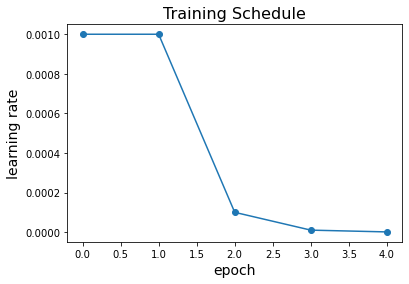

In [41]:
# CUSTOM LEARNING SCHEUDLE

def lrfn(epoch):
    rates = [1e-3,1e-3,1e-4,1e-5,1e-6]
    return rates[epoch]
    
lr = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(5)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y,'-o'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

# Train Model

In [42]:
WEIGHT_PATH = './'

In [43]:
for fold in range(5):
    if fold>DO_FOLDS-1: continue
    
    print('#'*25)
    print('### FOLD %i'%(fold+1))
    
    # TRAIN DATA
    if TRAIN_WITH_TEST:
        train = raw.loc[ (raw.fold!=fold)&(raw.dcount>0)&
                    ((raw.istest==0)|( (raw.istest==1)&(raw.icount>0)&(raw.reverse==0) )) ].copy()
    else:
        train = raw.loc[ (raw.fold!=fold)&(raw.dcount>0)&(raw.istest==0) ].copy()
        
    # VALIDATION DATA
    valid = raw.loc[ (raw.fold==fold)&(raw.istest==0)&(raw.icount==0)&(raw.N>=4)&(raw.reverse==0) ].copy()

    print('### train shape',train.shape,'valid shape', valid.shape)    
    print('#'*25)
        
    # SAVE BEST VAL SCORE EPOCH MODEL
    sv = tf.keras.callbacks.ModelCheckpoint(
        f'{WEIGHT_PATH}/MLPx_fold{fold}_v{VER}.h5', monitor='val_weighted_sum_sparse_top_k_categorical_accuracy', verbose=1, 
        save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch'
    )
        
    model = build_model()
    model.fit(train[FEATURES].to_pandas(),train[TARGET].to_pandas(),
          validation_data = (valid[FEATURES].to_pandas(),valid[TARGET].to_pandas()),
          epochs=5,verbose=1,batch_size=512, callbacks=[sv,lr])
    del train, valid
    gc.collect()

#########################
### FOLD 1
### train shape (1708302, 50) valid shape (43376, 50)
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
3337/3337 [==============================] - 670s 199ms/step - loss: 22.0424 - main_output_loss: 4.9967 - emb_dot_soft_max_loss: 6.0366 - emb_dot_soft_max_1_loss: 6.0469 - weighted_sum_loss: 4.9621 - main_output_sparse_top_k_categorical_accuracy: 0.4000 - emb_dot_soft_max_sparse_top_k_categorical_accuracy: 0.3950 - emb_dot_soft_max_1_sparse_top_k_categorical_accuracy: 0.3928 - weighted_sum_sparse_top_k_categorical_accuracy: 0.4029 - val_loss: 16.3836 - val_main_output_loss: 3.7150 - val_emb_dot_soft_max_loss: 4.4797 - val_emb_dot_soft_max_1_loss: 4.4918 - val_weighted_sum_loss: 3.6971 - val_main_output_sparse_top_k_categorical_accuracy: 0.5435 - val_emb_dot_soft_max_sparse_top_k_categorical_accuracy: 0.5365 - val_emb_dot_soft_max_1_sparse_top_k_categorical_accuracy: 0.5348 - val_weighted_sum_sparse_top_

# Validate Full OOF

In [44]:
city_mapping = MAPS[0].reset_index()

In [45]:
# PREDICT IN CHUNKS
# OTHERWISE DGX DIES

CHUNK = 1024*4

models = []
for k in range(DO_FOLDS):
    if k>DO_FOLDS-1: continue
    model = build_model()
    name = f'{WEIGHT_PATH}/MLPx_fold{k}_v{VER}.h5'
    print(name)
    model.load_weights(name)
    models.append(model)

valid = []

for fold in range(5):
    if fold>DO_FOLDS-1: continue
    print('#'*25)
    print('### FOLD %i'%(fold+1))
    
    test = raw.loc[ (raw.N>=4)&(raw.fold==fold)&(raw.reverse==0)&
                   ( ((raw.istest==0)&(raw.icount<=1)) | ((raw.istest==1)&(raw.icount==1)) ) ].copy()
        
    print('### valid shape', test.shape )
    print('#'*25)

    test.reset_index(drop=True,inplace=True)
    TOP4 = np.zeros((test.shape[0],4))

    print( test.shape )
    for k in range(test.shape[0]//CHUNK + 1):
        a = k*CHUNK
        b = (k+1)*CHUNK
        b = min(test.shape[0],b)
    
        print('Fold %i Chunk %i to %i'%(fold,a,b))
        _,_,_,preds = models[fold].predict(test[FEATURES].iloc[a:b].to_pandas(),verbose=0,batch_size=512)
        for i in range(4):
            x = np.argmax(preds,axis=1)
            TOP4[a:b,i] = x
            for j in range(preds.shape[0]):
                preds[j,x[j]] = -1
                
    for k in range(4):
        test['rec%i'%k] = TOP4[:,k] - 1
        tmp = test[['rec%i'%k]].astype('int32').copy()
        tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
        tmp = tmp.merge(city_mapping, how='left', left_on='rec%i'%k, right_on='index')
        tmp = tmp.sort_values('sorting')
        test['rec%i'%k] = tmp['city_id'].values.copy()
    valid.append(test)

.//MLPx_fold0_v44.h5
#########################
### FOLD 1
### valid shape (100870, 50)
#########################
(100870, 50)
Fold 0 Chunk 0 to 4096
Fold 0 Chunk 4096 to 8192
Fold 0 Chunk 8192 to 12288
Fold 0 Chunk 12288 to 16384
Fold 0 Chunk 16384 to 20480
Fold 0 Chunk 20480 to 24576
Fold 0 Chunk 24576 to 28672
Fold 0 Chunk 28672 to 32768
Fold 0 Chunk 32768 to 36864
Fold 0 Chunk 36864 to 40960
Fold 0 Chunk 40960 to 45056
Fold 0 Chunk 45056 to 49152
Fold 0 Chunk 49152 to 53248
Fold 0 Chunk 53248 to 57344
Fold 0 Chunk 57344 to 61440
Fold 0 Chunk 61440 to 65536
Fold 0 Chunk 65536 to 69632
Fold 0 Chunk 69632 to 73728
Fold 0 Chunk 73728 to 77824
Fold 0 Chunk 77824 to 81920
Fold 0 Chunk 81920 to 86016
Fold 0 Chunk 86016 to 90112
Fold 0 Chunk 90112 to 94208
Fold 0 Chunk 94208 to 98304
Fold 0 Chunk 98304 to 100870


In [46]:
if DO_FOLDS==1:
    valid = valid[0]
else:
    valid = cudf.concat(valid,axis=0,ignore_index=True)

In [47]:
# VALIDATION LAST CITY - FULL OOF
top4_metric( valid, 0, 0, target='city_id' )

0.5452554407967539

In [48]:
# VALIDATION 2ND LAST CITY - FULL OOF
top4_metric( valid, 0, 1, target='city_id' )

0.4884498340095906

In [49]:
# TEST 2ND LAST CITY 
top4_metric( valid, 1, 1, target='city_id' )

0.5014874628134297

# Validate Test 2nd Last City - 5 Folds

In [63]:
test = raw.loc[ (raw.istest==1)&(raw.icount==1)&(raw.reverse==0) ].copy()
print( test.shape )
test.head()

(70662, 50)


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
8,1266569,2016-09-12,2016-09-14,47193,mobile,359,Tcherkistan,Drusselstein,1266569_1,1,1,0,5,27382,3,1,0,73256,9,0,2,2,1,1,139,3,42,1,3,52,0,2,16863,16863,2990,0,0,0,13,2990,-6
24,1266616,2016-08-11,2016-08-12,40521,desktop,9924,The Devilfire Empire,Fook Island,1266616_1,1,4,0,8,27386,6,1,0,73272,8,3,4,4,0,0,3341,4,52,1,6,52,0,2,398,33416,11139,33232,33302,53,10,10114,-8
51,1263441,2016-12-16,2016-12-18,51291,desktop,2661,The Devilfire Empire,Glubbdubdrib,1263441_4,1,4,0,10,27066,8,1,0,72403,12,4,6,6,1,0,891,4,59,1,8,52,0,3,8042,15547,28084,18022,10866,60,13,1231,-10
59,1263538,2016-08-10,2016-08-11,13150,desktop,5755,Gondal,Alvonia,1263538_1,1,3,0,4,27070,2,1,0,72411,8,2,3,3,0,0,1961,2,5,1,2,52,0,2,39884,39903,0,0,0,0,5,39903,-2
63,1263546,2016-06-15,2016-06-16,26235,desktop,9924,The Devilfire Empire,Alvonia,1263546_1,1,1,0,4,27072,2,1,0,72415,6,2,3,3,0,0,3341,4,5,1,2,52,0,1,37736,15547,0,0,0,0,4,15547,-2


In [64]:
# PREDICT IN CHUNKS
# OTHERWISE DGX DIES

CHUNK = 1024*8
test.reset_index(drop=True,inplace=True)
TOP4 = np.zeros((test.shape[0],4))

print( test.shape )
for k in range(test.shape[0]//CHUNK + 1):
    if (not DO_TEST)|(TRAIN_WITH_TEST): continue
    a = k*CHUNK
    b = (k+1)*CHUNK
    b = min(test.shape[0],b)
    
    preds = np.zeros((b-a,t_ct))
    for j in range(1):
        print('Fold %i Chunk %i to %i'%(j,a,b))
        test_ = test[FEATURES].iloc[a:b].copy()      
        _,_,_,preds0 = models[j].predict(test_.to_pandas(),verbose=0,batch_size=512)
        preds += preds0
    preds /= 1.0
        
    for i in range(4):
        x = np.argmax(preds,axis=1)
        TOP4[a:b,i] = x
        for j in range(preds.shape[0]):
            preds[j,x[j]] = -1

(70662, 50)


In [68]:
if not((not DO_TEST)|(TRAIN_WITH_TEST)):
    for k in range(4):
        test['rec%i'%k] = TOP4[:,k] - 1
        tmp = test[['rec%i'%k]].astype('int32').copy()
        tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
        tmp = tmp.merge(city_mapping, how='left', left_on='rec%i'%k, right_on='index')
        tmp = tmp.sort_values('sorting')
        test['rec%i'%k] = tmp['city_id'].values.copy()
    # TEST 2ND LAST CITY
    # WITHOUT FOLD ENSEMBLE HAS 0.4278
    top4_metric( test, 1, 1, target='city_id' )

# Predict Test Last City Data - 5 Folds - Submission.csv

In [69]:
test = raw.loc[ (raw.istest==1)&(raw.icount==0)&(raw.reverse==0) ].copy()
print( test.shape )
test.head()

(70662, 50)


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
9,1266569,2016-09-14,2016-09-19,0,mobile,359,Tcherkistan,<NA>,1266569_1,1,1,1,5,27382,4,0,0,73257,9,2,0,0,4,1,139,3,-1,0,4,52,0,2,27964,16863,16863,2990,0,0,13,2990,-6
25,1266616,2016-08-12,2016-08-13,0,desktop,9924,The Devilfire Empire,<NA>,1266616_1,1,4,1,8,27386,7,0,0,73273,8,4,5,5,0,0,3341,4,-1,0,7,52,0,2,23964,398,33416,11139,33232,33,10,10114,-8
52,1263441,2016-12-18,2016-12-20,0,desktop,3634,The Devilfire Empire,<NA>,1263441_4,1,4,1,10,27066,9,0,0,72404,12,6,1,1,1,0,1240,4,-1,0,9,52,1,3,30332,8042,15547,28084,18022,60,13,1231,-10
60,1263538,2016-08-11,2016-08-13,0,desktop,5755,Gondal,<NA>,1263538_1,1,3,1,4,27070,3,0,0,72412,8,3,5,5,1,0,1961,2,-1,0,3,52,0,2,7832,39884,39903,0,0,0,5,39903,-2
96,1242918,2016-06-26,2016-06-27,0,mobile,359,The Devilfire Empire,<NA>,1242918_3,1,3,1,4,24940,3,0,0,66688,6,6,0,0,0,1,139,4,-1,0,3,52,1,1,32233,34421,39903,0,0,0,4,39903,-2


In [70]:
# PREDICT IN CHUNKS
# OTHERWISE DGX DIES
CHUNK = 1024*8
test.reset_index(drop=True,inplace=True)

TOP4 = np.zeros((test.shape[0],4))

print( test.shape )
for k in range(test.shape[0]//CHUNK + 1):
    if not DO_TEST: continue
    a = k*CHUNK
    b = (k+1)*CHUNK
    b = min(test.shape[0],b)
        
    preds = np.zeros((b-a,t_ct))
    for j in range(DO_FOLDS):
        print('Fold %i Chunk %i to %i'%(j,a,b))
        test_ = test[FEATURES].iloc[a:b].copy()       
        _,_,_,preds0 = models[j].predict(test_.to_pandas(),verbose=0,batch_size=512)
        preds += preds0
    preds /= 5.0
    
    for i in range(4):
        x = np.argmax(preds,axis=1)
        TOP4[a:b,i] = x
        for j in range(preds.shape[0]):
            preds[j,x[j]] = -1

(70662, 50)
Fold 0 Chunk 0 to 8192
Fold 0 Chunk 8192 to 16384
Fold 0 Chunk 16384 to 24576
Fold 0 Chunk 24576 to 32768
Fold 0 Chunk 32768 to 40960
Fold 0 Chunk 40960 to 49152
Fold 0 Chunk 49152 to 57344
Fold 0 Chunk 57344 to 65536
Fold 0 Chunk 65536 to 70662


In [75]:
COLS = ['utrip_id']
for k in range(4):
    test['city_id_%i'%(k+1)] = TOP4[:,k] - 1
    tmp = test[['city_id_%i'%(k+1)]].astype('int32').copy()
    tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
    tmp = tmp.merge(city_mapping, how='left', left_on='city_id_%i'%(k+1), right_on='index')
    tmp = tmp.sort_values('sorting')
    test['city_id_%i'%(k+1)] = tmp['city_id'].values.copy()
    COLS.append('city_id_%i'%(k+1))

In [76]:
test[COLS].head()

,utrip_id,city_id_1,city_id_2,city_id_3,city_id_4
0,1266569_1,2416,47193,7246,5049
1,1266616_1,55128,64876,17127,9608
2,1263441_4,3763,51291,3505,26235
3,1263538_1,26235,21555,1703,63342
4,1242918_3,60002,1034,54465,27115


In [77]:
if DO_TEST:
    test[COLS].to_csv('submission-MLPx-RNN_v%i.csv'%VER,index=False)